In [1]:
from google.colab import drive
drive.mount('/content/drive')

import keras
from keras.callbacks import Callback
from keras.layers import Input, Conv2D, Conv2DTranspose, Add, Activation
from keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import math
from torch.utils.data import Dataset, DataLoader, TensorDataset
from pathlib import Path
import torch
from tqdm import tqdm
from collections import defaultdict
import os

print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

Mounted at /content/drive
GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
# Here you need to specify the path where the 'preprocessed_data' folder is


# Moritz's
base = Path.cwd() / 'drive' / 'MyDrive' / 'Colab' / 'image-reconstruction-cv23'

# Max's
#base = Path.cwd() / 'drive' / 'MyDrive' / 'cvue23' / 'preprocessed_data'

In [5]:
map_label_to_name = ['no_person', 'idle','sitting', 'laying']

class DataGenerator(keras.utils.Sequence):
    def __init__(self, basedir: Path, batch_size: int, filter_no_person: bool, filter_no_trees: bool):
        if not basedir.exists():
            ValueError('Datafolder does not exist. Add it to your drive and try again. Maybe restart the runtime.')

        self.basedir = basedir
        self.batch_size = batch_size
        self.filter_no_person = filter_no_person
        self.filter_no_trees  = filter_no_trees
        self.filenames = self.__filter()

    def __filter(self):

        files = []
        self.pose_distribution = defaultdict(int)
        self.trees_distribution = defaultdict(int)

        for i, path in tqdm(enumerate(self.basedir.iterdir()), total=4815):

            loaded = np.load(path)
            pose, trees = loaded['pose'], loaded['trees']

            self.pose_distribution[pose.item()] += 1
            self.trees_distribution[trees.item()] += 1

            fname = path.name
            if self.filter_no_person and pose == 0:
                continue
            elif self.filter_no_trees and trees == 0:
                continue
            else:
                files.append(fname)

        return files

    def load(self, path):
        loaded = np.load(path)
        x = loaded['x'] / 255
        y = loaded['y'] / 255
        return x, y

    def __len__(self):
        return math.ceil(len(self.filenames) / self.batch_size)

    def __getitem__(self, idx):
        low = idx * self.batch_size
        high = min(low + self.batch_size, len(self.filenames))

        X, Y = [],[]
        for fname in self.filenames[low:high]:
            x,y = self.load(self.basedir / fname)
            X.append(x)
            Y.append(y)

        return np.stack(X), np.stack(Y)

    def print_distribution(self):
        print(f'Pose distribution (filtered={self.filter_no_person})')
        for key, value in self.pose_distribution.items():
            print(f'{map_label_to_name[key]} - {value}')

        print(f'Trees distribution (filtered={self.filter_no_trees})')
        for key, value in self.trees_distribution.items():
            print(f'{key} trees per ha - {value}')

datagen = DataGenerator(
    basedir=base / 'training_set',
    batch_size=16,
    filter_no_person=True,
    filter_no_trees=False
)

100%|██████████| 4815/4815 [00:08<00:00, 537.63it/s]


In [6]:
# you can set the batchsize later, no need to reload and refilter
datagen.batch_size=16
print(len(datagen))

# changing batch_size changes length
datagen.batch_size=1
print(len(datagen))

# check out the distribution of the samples
datagen.print_distribution()

# load a sample batch and check the shape
datagen.batch_size=16
_x, _y = datagen[0]
print(_x.shape, _y.shape)

274
4374
Pose distribution (filtered=True)
sitting - 1431
idle - 1442
laying - 1501
no_person - 441
Trees distribution (filtered=False)
0 trees per ha - 524
100 trees per ha - 2892
200 trees per ha - 1399
(16, 128, 128, 6) (16, 128, 128)


In [7]:
# for debugging
def plot_image_grid(images_array, grid_width=10, grid_height=10):

    if images_array.shape[0] != grid_width * grid_height:
        raise ValueError("The number of images does not match the grid size.")

    fig, axes = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images_array[i], cmap='gray', interpolation='none')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def encoder(x, num_features, num_layers, residual_every=2):
    x = Conv2D(num_features, kernel_size=3, strides=2, padding='same', activation='relu')(x)

    # Save the output of conv layers at even indices
    residuals = []

    # Encoder
    for i in range(num_layers - 1):
        x = Conv2D(num_features, kernel_size=3, padding='same', activation='relu')(x)
        if (i + 1) % residual_every == 0:
            residuals.append(x)

    return x, residuals

def decoder(x, num_features, num_layers, residuals, residual_every=2):

    # Decoder
    for i in range(num_layers - 1):
        x = Conv2DTranspose(num_features, kernel_size=3, padding='same')(x)

        if (i + 1 + num_layers) % residual_every == 0 and residuals:
            res = residuals.pop()
            x = Add()([x, res])

        x = Activation('relu')(x)

    if residuals: raise ValueError('There are unused residual connections')

    # create 1-channel output
    x = Conv2DTranspose(1, kernel_size=3, strides=2, padding='same')(x)

    return x

def REDNet(num_layers, num_features, channel_size):
    '''Model definition with keras functional layers api'''

    inputs = Input(shape=(None, None, channel_size))

    x, residuals = encoder(inputs, num_features, num_layers)

    x = decoder(x, num_features, num_layers, residuals)

    # Add input residual, needed to do 1x1 conv to adapt channels
    residual = Conv2DTranspose(1, kernel_size=1, padding='same')(inputs)
    outputs = Add()([x, residual])
    outputs = Activation('relu')(outputs)

    # Create model
    model = Model(inputs=inputs, outputs=outputs, name=f'REDNet{num_layers*2}')
    return model

class PredictionCallback(Callback):
    def __init__(self, interval, x_val, y_val):
        super(PredictionCallback, self).__init__()
        self.interval = interval
        self.x_val = x_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            preds = self.model.predict(self.x_val).squeeze()
            plot_image_grid(np.concatenate([self.x_val[:,:,:,1], preds, self.y_val]), preds.shape[0], 3)

In [ ]:
def pack_arrays(directory):

    '''
    Function that goes into a directory filled with .npz files and
    gets the first 100 of them and puts them into a new .npz box.

    This is used in the 'load_data' function below, which makes a validation set
    '''

    files = sorted([f for f in os.listdir(directory) if f.endswith('.npz')])[:100]
    x_arrays = []
    y_arrays = []
    for file in tqdm(files):
        data = np.load(os.path.join(directory, file))
        x_arrays.append(data['x'])
        y_arrays.append(data['y'])
    x_stacked = np.stack(x_arrays, axis=0)
    y_stacked = np.stack(y_arrays, axis=0)
    print("\n",os.path.join(directory.parent, 'packed.npz'))
    np.savez(os.path.join(directory.parent, 'packed.npz'), x=x_stacked, y=y_stacked)

pack_arrays(base / "validation_set_cropped")

In [9]:
def load_data(path):
  # load the mini dataset
  loaded = np.load(path)
  x, y = loaded['x'], loaded['y']

  # normalize dataset
  assert y.max() == 255
  assert x.max() == 255

  y = y / 255
  x = x / 255
  return x, y

x_val, y_val = load_data(base / 'packed.npz')


In [10]:
CHANNEL_SIZE = 6
NUM_LAYERS = 9
NUM_FEATURES = 64
LR = 0.00001

# compile the model
model = REDNet(
    num_layers=NUM_LAYERS,
    num_features=NUM_FEATURES,
    channel_size=CHANNEL_SIZE
)

opt = keras.optimizers.Adam(
    learning_rate=LR
)

loss = keras.losses.MeanSquaredError(
    reduction="sum_over_batch_size",
    name="mse"
)

model.compile(loss=loss,optimizer=opt)

In [ ]:
# Callbacks for training

class ExtraValidation(Callback):
    '''
    This custom callback lets us use a second validation set during training.
    Apart from the val set with cropped images, we could track validation loss
    on the whole images as well.

    Args:
    datagen object of the second validation set
    the frequency at which validation loss should be recorded (default: every epoch)

    Saves val2_loss into the "history" object coming out of model.fit in keras
    and can be plotted together with the other losses
    '''
    def __init__(self, validation_data, validation_freq=1):
        super(ExtraValidation, self).__init__()

        self.validation_data = validation_data
        self.validation_freq = validation_freq

    def on_epoch_end(self, epoch, logs=None):
        # evaluate at an interval of `validation_freq` epochs
        if (epoch + 1) % self.validation_freq == 0:
            # gather the evaluation metrics
            scores = self.model.evaluate(self.validation_data, verbose=2)

            # add the validation loss to the logs dictionary
            logs['val2_loss'] = scores[0]

# need to create datagen object before
#second_val_callback = ExtraValidation(val2_datagen)



prediction_callback = PredictionCallback(interval=2, x_val=x_val[:8], y_val=y_val[:8])



checkpoint_filepath = os.path.join(base, "model_checkpoints")

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                filepath=checkpoint_filepath,
                                                save_best_only=True)



# early stopping: tracks validation loss and if it hasn't gone down for 3 epochs, it stops
early_stopping_callback = keras.callbacks.EarlyStopping(patience=3)

Epoch 1/20
1/1 [==============================] - 1s 635ms/step


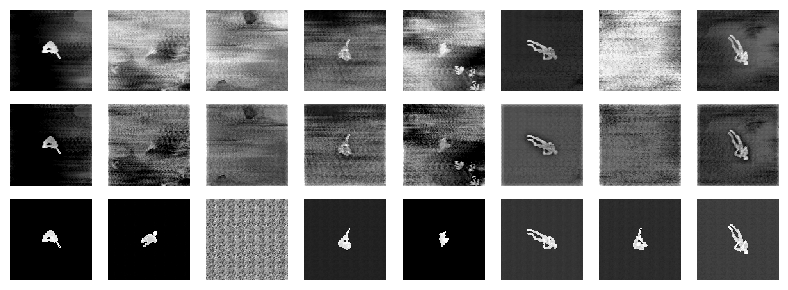

274/274 [==============================] - 37s 99ms/step - loss: 0.0773 - val_loss: 0.0450
Epoch 2/20
274/274 [==============================] - 24s 89ms/step - loss: 0.0437 - val_loss: 0.0384
Epoch 3/20
1/1 [==============================] - 0s 29ms/step


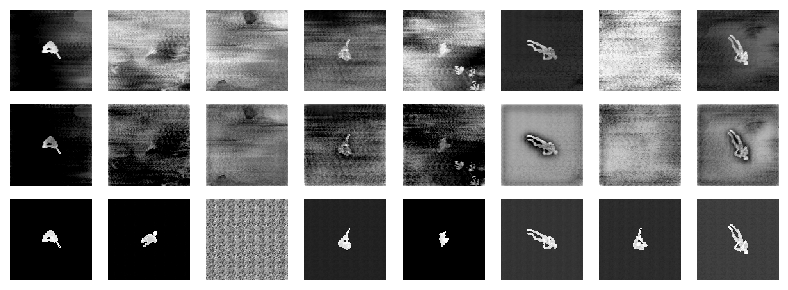

274/274 [==============================] - 26s 93ms/step - loss: 0.0381 - val_loss: 0.0349
Epoch 4/20
274/274 [==============================] - 24s 89ms/step - loss: 0.0331 - val_loss: 0.0297
Epoch 5/20
1/1 [==============================] - 0s 23ms/step


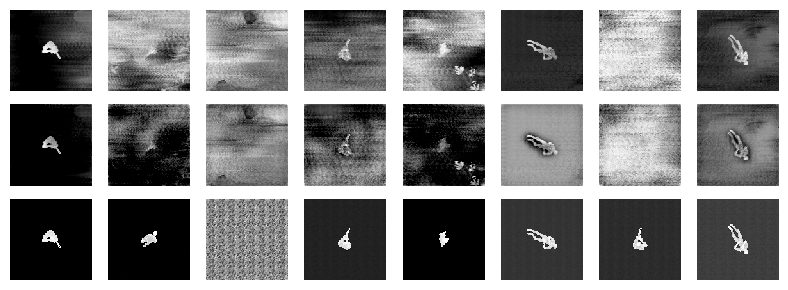

274/274 [==============================] - 26s 94ms/step - loss: 0.0294 - val_loss: 0.0276
Epoch 6/20
274/274 [==============================] - 25s 92ms/step - loss: 0.0269 - val_loss: 0.0255
Epoch 7/20
1/1 [==============================] - 0s 23ms/step


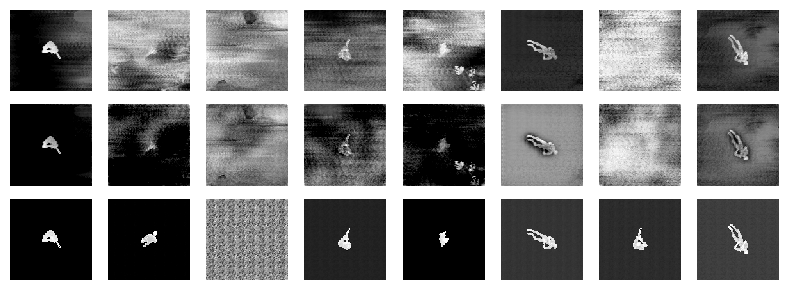

274/274 [==============================] - 25s 91ms/step - loss: 0.0255 - val_loss: 0.0251
Epoch 8/20
274/274 [==============================] - 24s 86ms/step - loss: 0.0249 - val_loss: 0.0247
Epoch 9/20
1/1 [==============================] - 0s 33ms/step


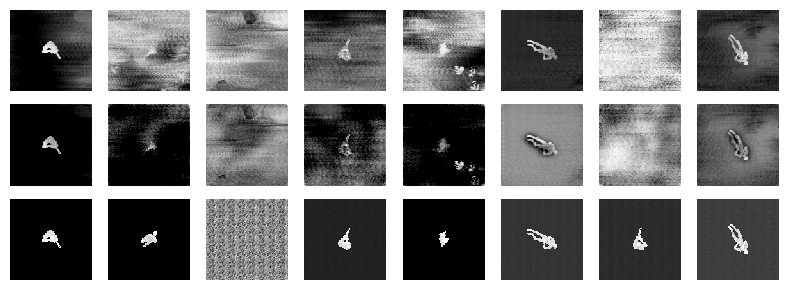

274/274 [==============================] - 23s 84ms/step - loss: 0.0249 - val_loss: 0.0281
Epoch 10/20
274/274 [==============================] - 25s 91ms/step - loss: 0.0238 - val_loss: 0.0241
Epoch 11/20
1/1 [==============================] - 0s 29ms/step


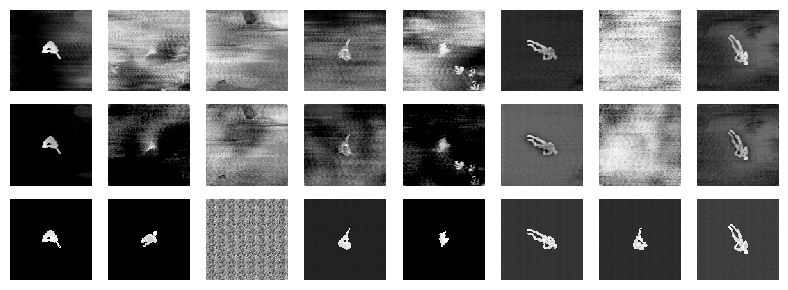

274/274 [==============================] - 27s 98ms/step - loss: 0.0243 - val_loss: 0.0226
Epoch 12/20
274/274 [==============================] - 21s 76ms/step - loss: 0.0234 - val_loss: 0.0231
Epoch 13/20
1/1 [==============================] - 0s 31ms/step


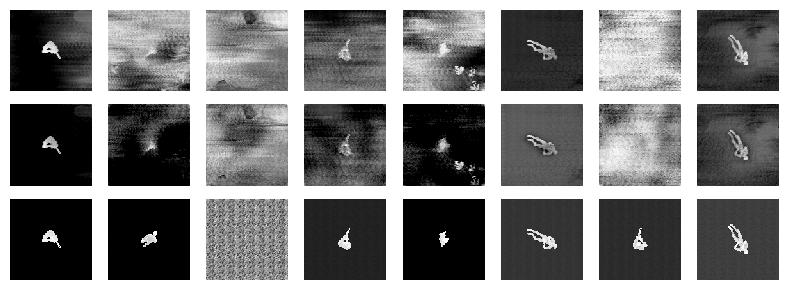

274/274 [==============================] - 26s 96ms/step - loss: 0.0236 - val_loss: 0.0225
Epoch 14/20
274/274 [==============================] - 26s 93ms/step - loss: 0.0224 - val_loss: 0.0220
Epoch 15/20
1/1 [==============================] - 0s 22ms/step


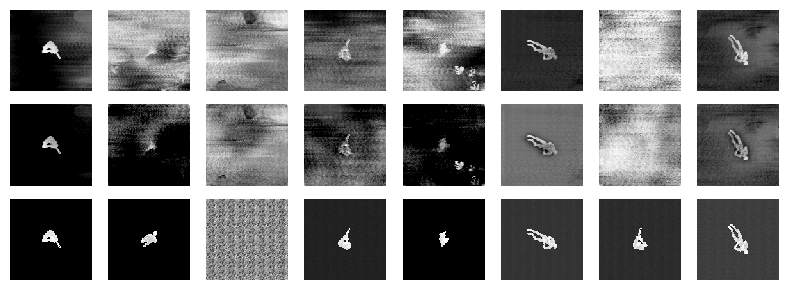

274/274 [==============================] - 23s 85ms/step - loss: 0.0235 - val_loss: 0.0233
Epoch 16/20
274/274 [==============================] - 33s 121ms/step - loss: 0.0222 - val_loss: 0.0267
Epoch 17/20
1/1 [==============================] - 0s 69ms/step


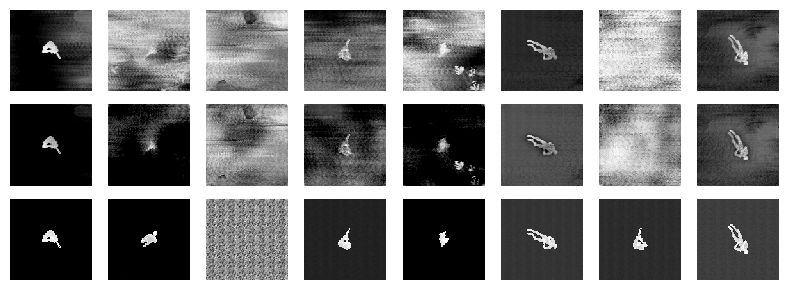

274/274 [==============================] - 33s 119ms/step - loss: 0.0221 - val_loss: 0.0223
Epoch 18/20
274/274 [==============================] - 23s 85ms/step - loss: 0.0224 - val_loss: 0.0231
Epoch 19/20
1/1 [==============================] - 0s 20ms/step


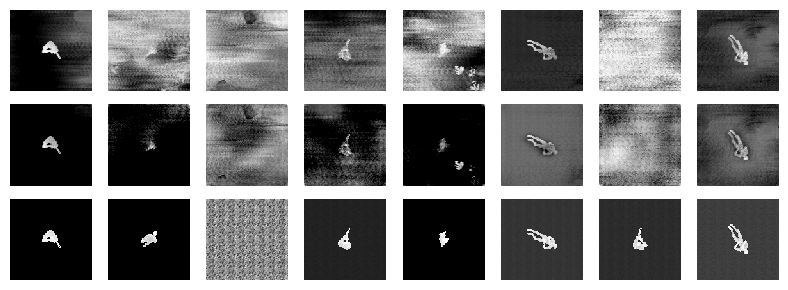

274/274 [==============================] - 23s 84ms/step - loss: 0.0215 - val_loss: 0.0351
Epoch 20/20
274/274 [==============================] - 29s 106ms/step - loss: 0.0216 - val_loss: 0.0220


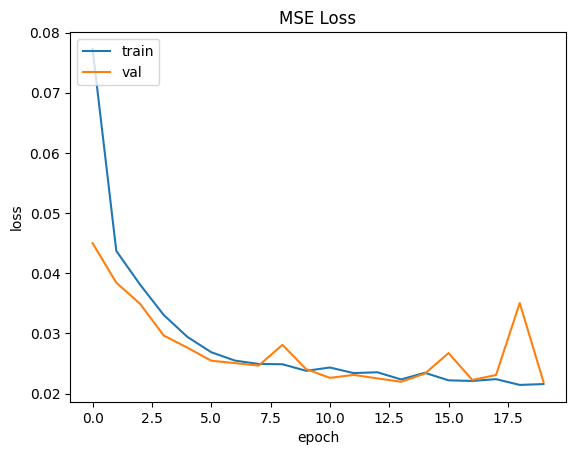

In [11]:
# Load best model weights if any weights have been stored
#model.load_weights(checkpoint_filepath)

# train on the dataset
history = model.fit(
    x=datagen,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[prediction_callback,
               model_checkpoint_callback,
               #second_val_callback,
               early_stopping_callback],
    shuffle=True,
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val2_loss'])
plt.title('MSE Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val cropped', 'val whole'], loc='upper right')
plt.show()